In [9]:
import os
import torch
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from itertools import product
import json
from collections import defaultdict

from torch import nn
from torch.autograd import Variable
from torch.functional import F
from torchvision import models
import torchvision
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

# from fastai import transforms, model, dataset, conv_learner

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from augmentation import SSDAugmentation

from Config import Config
from SSD_model import get_SSD_model, lr_find
from VOC_data import VOC_dataset

torch.set_printoptions(precision=3)

In [10]:
def detection_collate_fn(batch):
    imgs, bboxes, labels = [], [], []
    for i, b, l in batch:
        imgs.append(i); bboxes.append(b); labels.append(l)
    return torch.stack(imgs), bboxes, labels

In [11]:
config = Config('remote')
ssd_model = get_SSD_model(1, config.vgg_weight_path, config.vgg_reduced_weight_path)
ssd_model.freeze_basenet()

print(ssd_model.base_net[0].bias)

print('success build ssd model')

train_dataset = VOC_dataset(config.voc2007_root, config.voc2007_trn_anno)

# img, bbox, label = train_dataset[0]
# img = img.unsqueeze(0)

# conf_pred, loc_pred = ssd_model(img)
# print(conf_pred.shape, loc_pred.shape)
trn_dataloader = DataLoader(train_dataset, 16, shuffle=False, collate_fn=detection_collate_fn)
lr_array, loss_array = lr_find(ssd_model, 10, 1e-5, trn_dataloader)

/home/kindeqi/PyTorch_SSD/SSD_model.py:141: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)


Parameter containing:
tensor([ 0.734,  0.093,  0.068,  0.886,  0.260,  0.664, -0.016,  0.325,  0.686,
         0.062,  0.582,  0.236,  0.697,  0.195,  0.486,  0.446,  0.511,  0.209,
         0.576,  0.332,  0.500,  0.712,  0.303,  0.708,  0.045,  0.745,  0.298,
         0.482,  0.817,  0.626,  0.377,  2.064,  0.773,  0.346,  0.613,  0.655,
         0.390,  0.509,  0.263,  0.237,  0.080,  1.118,  0.261,  0.870,  0.215,
         0.780,  0.370,  0.480,  0.431,  0.508,  0.230,  0.764,  0.354,  0.458,
         0.466,  0.099,  0.380,  0.669,  0.402,  0.905,  0.432,  1.302,  0.531,
         0.490])
success build ssd model


  0%|          | 0/157 [00:00<?, ?it/s]/home/kindeqi/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 157/157 [04:45<00:00,  1.39s/it]


In [12]:
lr_array

[1e-05,
 1.0919847177985392e-05,
 1.1924306239055554e-05,
 1.3021160183398441e-05,
 1.4218907928277921e-05,
 1.5526830161463976e-05,
 1.6955061252172086e-05,
 1.8514667776710084e-05,
 2.0217734267284466e-05,
 2.2077456848386482e-05,
 2.4108245486294738e-05,
 2.632583564396947e-05,
 2.874741020649072e-05,
 3.1391732621773616e-05,
 3.427929228819466e-05,
 3.74324633156579e-05,
 4.0875677890252854e-05,
 4.463561558581175e-05,
 4.8741410089236725e-05,
 5.322487494139803e-05,
 5.812075004274507e-05,
 6.346697083366641e-05,
 6.930496223532932e-05,
 7.567995962858451e-05,
 8.26413593580247e-05,
 9.024310147706026e-05,
 9.854408769969258e-05,
 0.00010760863779746331,
 0.00011750698797794817,
 0.0001283158351064561,
 0.00014011893098780738,
 0.00015300773131295383,
 0.0001670821042987706,
 0.0001824511045118791,
 0.00019923381787243609,
 0.00021756028438535765,
 0.0002375725057487147,
 0.00025942554564670206,
 0.000283288731252746,
 0.00030934696525253605,
 0.00033780215855312506,
 0.0003688747

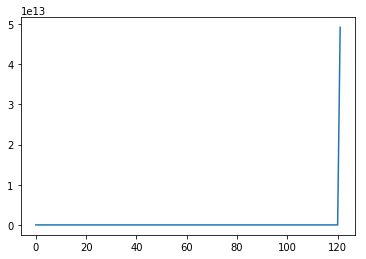

In [13]:
plt.plot(loss_array)

In [8]:
ssd_model.base_net[0].bias

Parameter containing:
tensor([ 0.734,  0.093,  0.068,  0.886,  0.260,  0.664, -0.016,  0.325,  0.686,
         0.062,  0.582,  0.236,  0.697,  0.195,  0.486,  0.446,  0.511,  0.209,
         0.576,  0.332,  0.500,  0.712,  0.303,  0.708,  0.045,  0.745,  0.298,
         0.482,  0.817,  0.626,  0.377,  2.064,  0.773,  0.346,  0.613,  0.655,
         0.390,  0.509,  0.263,  0.237,  0.080,  1.118,  0.261,  0.870,  0.215,
         0.780,  0.370,  0.480,  0.431,  0.508,  0.230,  0.764,  0.354,  0.458,
         0.466,  0.099,  0.380,  0.669,  0.402,  0.905,  0.432,  1.302,  0.531,
         0.490], device='cuda:0')

In [54]:
config = Config('local')
ssd_model = get_SSD_model(1, config.vgg_weight_path, config.vgg_reduced_weight_path)
ssd_model.freeze_basenet()

print('success build ssd model')

train_dataset = VOC_dataset(config.voc2007_root, config.voc2007_trn_anno)

# img, bbox, label = train_dataset[0]
# img = img.unsqueeze(0)

# conf_pred, loc_pred = ssd_model(img)
# print(conf_pred.shape, loc_pred.shape)

D:\1-usc\SSD_PyTorch\SSD_model.py:141: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)


success build ssd model


In [58]:
torch.save(ssd_model.state_dict(), 'tmp.pth')

In [61]:
for k in torch.load('tmp.pth').keys():
    print(k)

base_net.0.weight
base_net.0.bias
base_net.2.weight
base_net.2.bias
base_net.5.weight
base_net.5.bias
base_net.7.weight
base_net.7.bias
base_net.10.weight
base_net.10.bias
base_net.12.weight
base_net.12.bias
base_net.14.weight
base_net.14.bias
base_net.17.weight
base_net.17.bias
base_net.19.weight
base_net.19.bias
base_net.21.weight
base_net.21.bias
base_net.24.weight
base_net.24.bias
base_net.26.weight
base_net.26.bias
base_net.28.weight
base_net.28.bias
reduced_fc.1.weight
reduced_fc.1.bias
reduced_fc.3.weight
reduced_fc.3.bias
extra.0.weight
extra.0.bias
extra.1.weight
extra.1.bias
extra.2.weight
extra.2.bias
extra.3.weight
extra.3.bias
extra.4.weight
extra.4.bias
extra.5.weight
extra.5.bias
extra.6.weight
extra.6.bias
extra.7.weight
extra.7.bias
conf_layers.0.weight
conf_layers.0.bias
conf_layers.1.weight
conf_layers.1.bias
conf_layers.2.weight
conf_layers.2.bias
conf_layers.3.weight
conf_layers.3.bias
conf_layers.4.weight
conf_layers.4.bias
conf_layers.5.weight
conf_layers.5.bias


In [3]:
original_dict = ssd_model.state_dict()
reduced_fc_weight = torch.load(config.vgg_reduced_weight_path)

In [4]:
print(config.vgg_reduced_weight_path)

D:\1-usc\SSD_3rd party implementation\ssd.pytorch\weights\vgg16_reducedfc.pth


In [7]:
for k0, k1 in zip(original_dict.keys(), reduced_fc_weight.keys()):
    shape_equal = original_dict[k0].shape == reduced_fc_weight[k1].shape
    print('{:20s} {:20s} {}'.format(k0, k1, shape_equal))

base_net.0.weight    0.weight             True
base_net.0.bias      0.bias               True
base_net.2.weight    2.weight             True
base_net.2.bias      2.bias               True
base_net.5.weight    5.weight             True
base_net.5.bias      5.bias               True
base_net.7.weight    7.weight             True
base_net.7.bias      7.bias               True
base_net.10.weight   10.weight            True
base_net.10.bias     10.bias              True
base_net.12.weight   12.weight            True
base_net.12.bias     12.bias              True
base_net.14.weight   14.weight            True
base_net.14.bias     14.bias              True
base_net.17.weight   17.weight            True
base_net.17.bias     17.bias              True
base_net.19.weight   19.weight            True
base_net.19.bias     19.bias              True
base_net.21.weight   21.weight            True
base_net.21.bias     21.bias              True
base_net.24.weight   24.weight            True
base_net.24.b

In [8]:
original_dict['base_net.0.bias']

tensor([ 0.403,  0.378,  0.464, -0.323,  0.394, -0.395,  0.395, -0.550,  0.269,
        -0.760, -0.351,  0.233, -1.324, -0.169,  0.394, -0.103,  0.046, -0.700,
         0.155,  0.563,  0.301,  0.343,  0.107,  0.465,  0.129,  0.079, -0.049,
        -0.564,  0.147, -0.389, -0.071,  0.065,  0.277,  0.328,  0.568, -1.264,
        -0.837, -0.948,  0.136,  0.273,  0.184, -0.533,  0.351, -0.083, -1.025,
        -0.691, -0.771,  0.261,  0.403, -0.480, -0.307,  0.581, -1.333,  0.484,
        -0.816,  0.239,  0.230,  0.498,  0.555,  0.523, -0.218,  0.012, -0.552,
         0.211])

In [9]:
reduced_fc_weight['0.bias']

tensor([ 0.734,  0.093,  0.068,  0.886,  0.260,  0.664, -0.016,  0.325,  0.686,
         0.062,  0.582,  0.236,  0.697,  0.195,  0.486,  0.446,  0.511,  0.209,
         0.576,  0.332,  0.500,  0.712,  0.303,  0.708,  0.045,  0.745,  0.298,
         0.482,  0.817,  0.626,  0.377,  2.064,  0.773,  0.346,  0.613,  0.655,
         0.390,  0.509,  0.263,  0.237,  0.080,  1.118,  0.261,  0.870,  0.215,
         0.780,  0.370,  0.480,  0.431,  0.508,  0.230,  0.764,  0.354,  0.458,
         0.466,  0.099,  0.380,  0.669,  0.402,  0.905,  0.432,  1.302,  0.531,
         0.490])

In [10]:
for k0, k1 in zip(original_dict.keys(), reduced_fc_weight.keys()):
    original_dict[k0] = reduced_fc_weight[k1]

In [12]:
ssd_model.load_state_dict(original_dict)

In [13]:
ssd_model.base_net[0].bias

Parameter containing:
tensor([ 0.734,  0.093,  0.068,  0.886,  0.260,  0.664, -0.016,  0.325,  0.686,
         0.062,  0.582,  0.236,  0.697,  0.195,  0.486,  0.446,  0.511,  0.209,
         0.576,  0.332,  0.500,  0.712,  0.303,  0.708,  0.045,  0.745,  0.298,
         0.482,  0.817,  0.626,  0.377,  2.064,  0.773,  0.346,  0.613,  0.655,
         0.390,  0.509,  0.263,  0.237,  0.080,  1.118,  0.261,  0.870,  0.215,
         0.780,  0.370,  0.480,  0.431,  0.508,  0.230,  0.764,  0.354,  0.458,
         0.466,  0.099,  0.380,  0.669,  0.402,  0.905,  0.432,  1.302,  0.531,
         0.490])

In [21]:
base, ratio, batch_num = 1e-5, 1e6, 200

In [30]:
for idx, i in enumerate(range(batch_num)):
    lr = round(base * ratio ** (i / batch_num), 1)
    print(idx, ": ", lr)

0 :  0.0
1 :  0.0
2 :  0.0
3 :  0.0
4 :  0.0
5 :  0.0
6 :  0.0
7 :  0.0
8 :  0.0
9 :  0.0
10 :  0.0
11 :  0.0
12 :  0.0
13 :  0.0
14 :  0.0
15 :  0.0
16 :  0.0
17 :  0.0
18 :  0.0
19 :  0.0
20 :  0.0
21 :  0.0
22 :  0.0
23 :  0.0
24 :  0.0
25 :  0.0
26 :  0.0
27 :  0.0
28 :  0.0
29 :  0.0
30 :  0.0
31 :  0.0
32 :  0.0
33 :  0.0
34 :  0.0
35 :  0.0
36 :  0.0
37 :  0.0
38 :  0.0
39 :  0.0
40 :  0.0
41 :  0.0
42 :  0.0
43 :  0.0
44 :  0.0
45 :  0.0
46 :  0.0
47 :  0.0
48 :  0.0
49 :  0.0
50 :  0.0
51 :  0.0
52 :  0.0
53 :  0.0
54 :  0.0
55 :  0.0
56 :  0.0
57 :  0.0
58 :  0.0
59 :  0.0
60 :  0.0
61 :  0.0
62 :  0.0
63 :  0.0
64 :  0.0
65 :  0.0
66 :  0.0
67 :  0.0
68 :  0.0
69 :  0.0
70 :  0.0
71 :  0.0
72 :  0.0
73 :  0.0
74 :  0.0
75 :  0.0
76 :  0.0
77 :  0.0
78 :  0.0
79 :  0.0
80 :  0.0
81 :  0.0
82 :  0.0
83 :  0.0
84 :  0.0
85 :  0.0
86 :  0.0
87 :  0.0
88 :  0.0
89 :  0.0
90 :  0.0
91 :  0.0
92 :  0.0
93 :  0.0
94 :  0.0
95 :  0.0
96 :  0.0
97 :  0.0
98 :  0.0
99 :  0.0
100 :  0.0

In [22]:
reduced_fc_weight['classifier.0.weight'].shape

torch.Size([4096, 25088])

In [21]:
for t in ssd_model.state_dict():
    print(t)

base_net.0.weight
base_net.0.bias
base_net.2.weight
base_net.2.bias
base_net.5.weight
base_net.5.bias
base_net.7.weight
base_net.7.bias
base_net.10.weight
base_net.10.bias
base_net.12.weight
base_net.12.bias
base_net.14.weight
base_net.14.bias
base_net.17.weight
base_net.17.bias
base_net.19.weight
base_net.19.bias
base_net.21.weight
base_net.21.bias
base_net.24.weight
base_net.24.bias
base_net.26.weight
base_net.26.bias
base_net.28.weight
base_net.28.bias
reduced_fc.1.weight
reduced_fc.1.bias
reduced_fc.3.weight
reduced_fc.3.bias
extra.0.weight
extra.0.bias
extra.1.weight
extra.1.bias
extra.2.weight
extra.2.bias
extra.3.weight
extra.3.bias
extra.4.weight
extra.4.bias
extra.5.weight
extra.5.bias
extra.6.weight
extra.6.bias
extra.7.weight
extra.7.bias
conf_layers.0.weight
conf_layers.0.bias
conf_layers.1.weight
conf_layers.1.bias
conf_layers.2.weight
conf_layers.2.bias
conf_layers.3.weight
conf_layers.3.bias
conf_layers.4.weight
conf_layers.4.bias
conf_layers.5.weight
conf_layers.5.bias


In [3]:
ssd_model.freeze_basenet()

In [4]:
for k in ssd_model.parameters():
    print(k.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [13]:
x = torch.randn(4, 4)
w1 = nn.Parameter(torch.randn(4, 3))
b1 = nn.Parameter(torch.randn(1, 3))
y = torch.randn(4, 3)
pred = torch.matmul(x, w1) + b1

optimizer = torch.optim.Adam([w1, b1])
criterion = nn.SmoothL1Loss()
loss = criterion(pred, y)

In [14]:
w1.requires_grad = False

In [15]:
loss.backward(retain_graph=True)
# optimizer.step()

In [16]:
w1.grad

In [18]:
b1.grad

tensor([[ 0.118, -0.102, -0.116]])

In [19]:
w1

Parameter containing:
tensor([[-0.763, -0.043,  1.046],
        [ 1.506, -0.135, -1.143],
        [ 0.087, -0.807, -1.532],
        [-0.955,  0.441,  0.128]])

In [20]:
b1

Parameter containing:
tensor([[-0.445, -0.305,  0.973]], requires_grad=True)

In [21]:
optimizer.step()

In [22]:
w1

Parameter containing:
tensor([[-0.763, -0.043,  1.046],
        [ 1.506, -0.135, -1.143],
        [ 0.087, -0.807, -1.532],
        [-0.955,  0.441,  0.128]])

In [23]:
b1

Parameter containing:
tensor([[-0.446, -0.304,  0.974]], requires_grad=True)

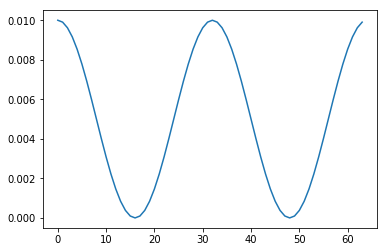

In [3]:
x = torch.randn(4, 4)
w = nn.Parameter(torch.randn(4, 3))
b = nn.Parameter(torch.randn(1, 3))
y = torch.randn(4, 3)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.SGD([w, b], lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 16)

epoch, batch = 4, 16

lr_array = []

for j in range(epoch):
    for k in range(batch):
        pred = torch.matmul(x, w) + b
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        lr_array.append(optimizer.param_groups[0]['lr'])

plt.plot(lr_array)

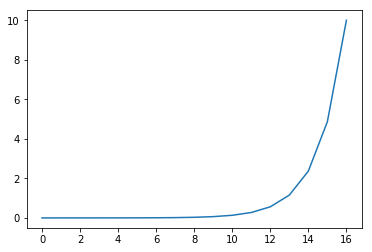

In [6]:
x = torch.randn(4, 4)
w = nn.Parameter(torch.randn(4, 3))
b = nn.Parameter(torch.randn(1, 3))
y = torch.randn(4, 3)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.SGD([w, b], lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 16)

lr_change = []
lr_min, lr_max = 1e-4, 10
ratio = lr_max / lr_min

for t in range(batch + 1):
    optimizer.param_groups[0]['lr'] = lr_min * ratio ** (t / batch)
    lr_change.append(lr_min * ratio ** (t / batch))
#     print(optimizer.param_groups[0]['lr'])

plt.plot(lr_change)